In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import lightgbm as lgb

In [2]:
X_data = np.load('new_peminer_train_features.npy')
Y_data= np.load('new_peminer_train_labels.npy') #데이터 불러오기

In [3]:
print(X_data.shape, Y_data.shape) #데이터 형태 확인

(20000, 188) (20000,)


In [4]:
df=pd.DataFrame(X_data)

In [5]:
normal=0
attack=0
for i in range(len(Y_data)):
    if Y_data[i]==0:
        normal=normal+1
    elif Y_data[i]==1:
        attack=attack+1

In [6]:
print("데이터의 분포\n normal data : {}\n attack data : {}\n".format(normal, attack)) #데이터 분포 확인

데이터의 분포
 normal data : 6000
 attack data : 14000



In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_data_scaler = scaler.fit_transform(X_data) #scaler 적용

In [8]:
#data를 train, val, test로 나눠주기 위해 train_test_split으로 한 번 나눠줌
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_data_scaler,Y_data, test_size=0.2, random_state=777, stratify=Y_data)

In [9]:
model = lgb.LGBMClassifier() #모델은 light gbm사용

In [10]:
skf = StratifiedKFold(n_splits=5)
k=5 #비율을 맞춰서 fold로 나눠주기 위해 stratifiedKFlod 사용

In [11]:
result_Y_val=[]
result_Y_val_pred=[]

i=0
for train_index,val_index in skf.split(X_train_val,Y_train_val):
    i=i+1
    print(str(i),"번째 cross validation")
    X_train = X_train_val[train_index] #train, test로 데이터 나누기
    Y_train = Y_train_val[train_index]  
    X_val = X_train_val[val_index]
    Y_val = Y_train_val[val_index]
    model.fit(X_train, Y_train) #모델 학습

    Y_val_pred = model.predict(X_val) #validation data 예측하기
    result_Y_val.append(Y_val)
    result_Y_val_pred.append(Y_val_pred)

1 번째 cross validation
2 번째 cross validation
3 번째 cross validation
4 번째 cross validation
5 번째 cross validation


In [12]:
Y_pred=model.predict(X_test) #test data 예측하기

In [13]:
#accuracy, precision, recall, f1-score, auc_score로 평가하는 함수
def evaluation(Y_test,y_pred):
    acc= accuracy_score(Y_test,y_pred)
    print("accuracy : {}".format(acc))
    prec= precision_score(Y_test,y_pred)
    print("precision : {}".format(prec))
    rec= recall_score(Y_test,y_pred)
    print("recall: {}".format(rec))
    f1= f1_score(Y_test,y_pred)
    print("F1-Score : {}".format(f1))
    auc_score=roc_auc_score(Y_test,y_pred)
    print("auc_score: {}".format(auc_score))


In [14]:
#매 fold마다 평가하기
for i in range(k):
    print("{} 번째 cross validation".format(i+1))
    evaluation(result_Y_val[i],result_Y_val_pred[i])
    print("\n")

1 번째 cross validation
accuracy : 0.9521875
precision : 0.9550806803314436
recall: 0.9776785714285714
F1-Score : 0.9662475181998676
auc_score: 0.9351934523809524


2 번째 cross validation
accuracy : 0.95125
precision : 0.9538327526132404
recall: 0.9776785714285714
F1-Score : 0.9656084656084656
auc_score: 0.9336309523809525


3 번째 cross validation
accuracy : 0.9471875
precision : 0.9559665345662703
recall: 0.9691964285714286
F1-Score : 0.962536023054755
auc_score: 0.932514880952381


4 번째 cross validation
accuracy : 0.9509375
precision : 0.9586085424922941
recall: 0.971875
F1-Score : 0.9651961870982043
auc_score: 0.9369791666666667


5 번째 cross validation
accuracy : 0.9546875
precision : 0.958826106000876
recall: 0.9772321428571429
F1-Score : 0.9679416316604025
auc_score: 0.9396577380952381




In [15]:
evaluation(Y_test,Y_pred) #test data의 성능 평가

accuracy : 0.954
precision : 0.9602392681210415
recall: 0.9746428571428571
F1-Score : 0.967387451258419
auc_score: 0.9402380952380953


In [16]:
import matplotlib.pyplot as plt

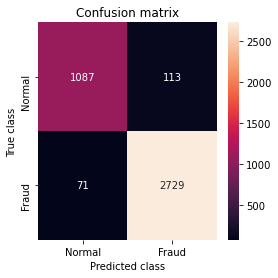

In [17]:
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [18]:
X_real_test = np.load('new_peminer_test_features.npy') #test data 불러오기

In [19]:
scaler = StandardScaler()
X_real_test_scaler = scaler.fit_transform(X_real_test) #scaler 적용

In [20]:
Y_real_test=model.predict(X_real_test_scaler) #학습

In [21]:
Y_real_test

array([0, 1, 1, ..., 1, 0, 1])

In [22]:
Y_real_test=np.array(Y_real_test)

In [23]:
np.savetxt('new_peminer_test_result.csv',Y_real_test,fmt='%d') #csv 파일로 저장

In [24]:
test_normal=0
test_attack=0
for i in range(len(Y_real_test)):
    if Y_real_test[i]==0:
        test_normal=test_normal+1
    elif Y_real_test[i]==1:
        test_attack=test_attack+1

In [25]:
print("데이터의 분포\n test_normal data : {}\n test_attack data : {}\n".format(test_normal, test_attack)) #데이터 분포 확인

데이터의 분포
 test_normal data : 8016
 test_attack data : 11984

